### About this notebook

The purpose of this notebook is to perform webscraping on a website containing early voting return results.  The resultant data is visualized and stored to file so it can be seen over time.

### Conda package from inside the the jupyter notebook

It is not necessary to run this cell if the needed libraries have already been installed.  It is placed here for convineience in case certain libraries need to be installed.  Must uncomment both lines to run.

In [1]:
#import sys
#!conda install --yes --prefix {sys.prefix} selenium

### Chrome driver download location

* https://chromedriver.storage.googleapis.com/index.html?path=2.42/

### Library Imports

In [49]:
import os
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### Get the total number of returned ballots

In [3]:
def get_total_ballots(driver):
    """Takes a driver and returns the total number of ballots returned"""
    
    try:             
        num_bal_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div[2]/h3/span'
        num_bal = driver.find_elements_by_xpath(num_bal_xpath)[0]
    except:
        num_bal_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div/h3/span'   
        num_bal = driver.find_elements_by_xpath(num_bal_xpath)[0]

    return int(num_bal.text.replace(",", ""))

### Click on the radio button "Party Registration"

In [58]:
def click_party_registration(driver):
    """Takes a driver and shows ballots returned by party registration"""
    
    party_reg_selector = "ballotReturnedDataParty registration"
    wait = WebDriverWait(driver, 10)
    radio = wait.until(EC.element_to_be_clickable((By.NAME, party_reg_selector)))
    radio.click()

### Get percentages from each party

In [5]:
def get_percentages(driver):
    """takes a driver and returns the percentage of ballots per party"""
    
    try:
        dem_perc_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div[2]/div/div[1]/figure/div/div[1]/span'
        gop_perc_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div[2]/div/div[1]/figure/div/div[2]/span'
        other_perc_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div[2]/div/div[1]/figure/div/div[3]/span[1]'

        dem_perc = driver.find_element_by_xpath(dem_perc_xpath)
        gop_perc = driver.find_element_by_xpath(gop_perc_xpath)
        other_perc = driver.find_element_by_xpath(other_perc_xpath)
    except:
        dem_perc_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div/div/div[1]/figure/div/div[1]/span'
        gop_perc_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div/div/div[1]/figure/div/div[2]/span'
        other_perc_xpath = '//*[@id="__next"]/div[4]/main/div[1]/div[2]/div/div/div[1]/figure/div/div[3]/span'
        
        dem_perc = driver.find_element_by_xpath(dem_perc_xpath)
        gop_perc = driver.find_element_by_xpath(gop_perc_xpath)
        other_perc = driver.find_element_by_xpath(other_perc_xpath)      
        

    dem = int(dem_perc.text.replace("%", ""))/100
    gop = int(gop_perc.text.replace("%", ""))/100
    other = int(other_perc.text.replace("%", ""))/100

    return (dem, gop, other)

### Compute votes for each party

In [6]:
def compute_votes(total_ballots, percentages):
    """Takes total number of votes and % by party and returns votes per party"""
    
    dem_votes = int(total_ballots*percentages[0]) 
    gop_votes = int(total_ballots*percentages[1]) 
    other_votes = int(total_ballots*percentages[2])

    return(dem_votes, gop_votes, other_votes)

### Visualize Results

In [34]:
def plot_all_states():
    """Takes a 12 state dataframe and plots 3 x 4 line graphs"""
    plt.figure(figsize=(14, 10))
    for state, abbrev in bg.items():
        i = list(bg.keys()).index(state)
        ax = plt.subplot(4, 3, i+1)
        ax.tick_params(labelbottom=False) 
        
        plt.title(f"{state.title()}")
        plt.plot(bg_2020.date, bg_2020[f"{abbrev}_dem"], color="blue")
        plt.plot(bg_2020.date, bg_2020[f"{abbrev}_gop"], color="red")
        plt.plot(bg_2020.date, bg_2020[f"{abbrev}_other"], color="grey")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        min_date = list(bg_2020.date)[0]
        max_date = list(bg_2020.date)[-1]
        
        plt.suptitle(f"Vote Counts by Party {min_date} to {max_date}", 
                     fontsize = 16, 
                     fontweight = 'bold')

### Data Source

In [8]:
url = "https://www.nbcnews.com/politics/2020-elections/"

### Battleground States

In [9]:
bg = {"colorado": "co",
      "florida": "fl",
      "iowa": "ia",
      "michigan": "mi",
      "minnesota": "mn",
      "nevada": "nv", 
      "new-hampshire": "nh",
      "north-carolina": "nc",
      "ohio": "oh",
      "pennsylvania": "pa",
      "virginia": "va",
      "wisconsin": "wi"}

### Main Workflow

colorado: (520692, 333777, 480639)
florida: (1891144, 1428864, 882534)
iowa: (335442, 199975, 109663)
michigan: (751916, 790475, 385598)
minnesota: (533613, 322391, 255689)
nevada: (239925, 185396, 119962)
new-hampshire: (60861, 22131, 27664)
north-carolina: (1120536, 773703, 773703)
ohio: (699051, 860371, 233017)
pennsylvania: (938932, 264488, 119019)
virginia: (842294, 594560, 214702)
wisconsin: (408538, 452705, 242914)
New Data Written to: daily_vote_counts.csv
Wall time: 1min 36s


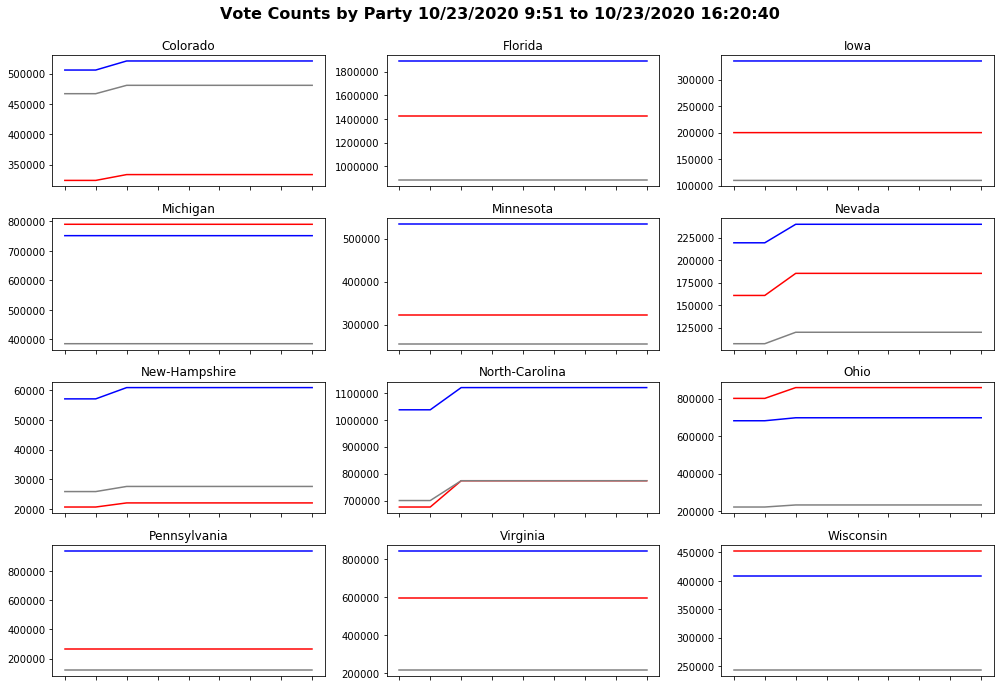

In [56]:
%%time
file = "daily_vote_counts.csv"
row = []
row.append(datetime.now().strftime("%m/%d/%Y %H:%M:%S"))

driver = webdriver.Chrome(r"C:\Users\N0R01DF\Downloads\chromedriver.exe")

# Get the vote breakdown from each state
for state in bg.keys():
    driver.get(f"{url}{state}-results")
    total_ballots = get_total_ballots(driver)
    click_party_registration(driver)
    percentages = get_percentages(driver)
    votes = compute_votes(total_ballots, percentages)
    print(f"{state}: {votes}")

    for vote_count in votes:
        row.append(vote_count)

# Create header names
header = ["date"]

for abbrev in bg.values():
    header.append(abbrev+"_dem")
    header.append(abbrev+"_gop")
    header.append(abbrev+"_other")

# Create a dataframe with the new data
new_data = pd.DataFrame(columns=header, data=[row])

# Append to exisitng file or write a new file
if os.path.exists(file):
    bg_2020 = pd.read_csv(file)
    bg_2020 = bg_2020.append(new_data)
    bg_2020.to_csv(file, index=False)
else:
    bg_2020 = new_data
    bg_2020.to_csv(file, index=False)
    
print("New Data Written to: " + file)

plot_all_states()